In [49]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import FileLink,display, Image
from PIL import Image as I

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files     
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from random import sample
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
import pickle
import zipfile
import os
import cv2
import timeit
import time
import h5py

In [50]:
# Create folder
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [51]:
# check if CUDA is available
if tf.test.is_gpu_available(cuda_only=True):
     print('CUDA is available!  Training on GPU ...')

IMG_SIZE   = 244 if  tf.test.is_gpu_available(cuda_only=True) else 160
COLOR_TYPE = 3
CLASSES    = 10
EPOCHS     = 50
BATCHES    = 50
IMG_SIZE   = 224
TEST_SIZE  = 10

CUDA is available!  Training on GPU ...


In [52]:
df = pd.read_csv("../input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


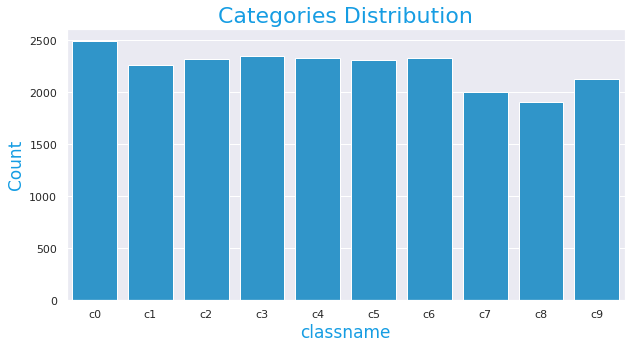

In [53]:
sns.set()

plt.figure(figsize = (10,5))
# Count the number of images per category
sns.countplot(x = 'classname', color = '#169DE3',data = df)

plt.title('Categories Distribution'.title(),size=22 , color = '#169DE3')
plt.xlabel('classname',size=17 , color = '#169DE3')
plt.ylabel('Count',size=17 , color = '#169DE3')

plt.show()

In [54]:
# Load the dataset from Kaggle
def get_cv2_image(path, img_size, color_type):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Loading as color image
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img[:500], (img_size, img_size)) 
    return img

In [55]:
def load_trainning_data(img_size , color_type):
    start_time = time.time()
    training_images = []
    training_labels = []

    # Loop over the training folder 
    for class_ in tqdm(range(CLASSES)):
        
        print('Loading directory c{}'.format(class_))
        
        files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train', 'c' + str(class_), '*.jpg'))
        
        for file in files:
            img = get_cv2_image(file, img_size , color_type)
            training_images.append(img)
            training_labels.append(class_) 
    
    print("Data Loaded in {} Min".format((time.time() - start_time)/60))
    return training_images, training_labels 

In [56]:
X, y = load_trainning_data( IMG_SIZE , COLOR_TYPE)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:10<01:31, 10.14s/it]

Loading directory c1


 20%|██        | 2/10 [00:28<02:00, 15.01s/it]

Loading directory c2


 30%|███       | 3/10 [00:50<02:08, 18.33s/it]

Loading directory c3


 40%|████      | 4/10 [01:13<02:00, 20.00s/it]

Loading directory c4


 50%|█████     | 5/10 [01:35<01:43, 20.69s/it]

Loading directory c5


 60%|██████    | 6/10 [01:57<01:24, 21.12s/it]

Loading directory c6


 70%|███████   | 7/10 [02:19<01:04, 21.40s/it]

Loading directory c7


 80%|████████  | 8/10 [02:38<00:41, 20.66s/it]

Loading directory c8


 90%|█████████ | 9/10 [02:56<00:19, 19.88s/it]

Loading directory c9


100%|██████████| 10/10 [03:16<00:00, 19.64s/it]

Data Loaded in 3.2741778969764708 Min


In [57]:
# Convert Categorical data to numerical
y = np_utils.to_categorical(y, CLASSES)
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [58]:
# splitting train data to train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15,shuffle=True, random_state=2021)
print(X_train[0])

[[[ 36  44  37]
  [ 34  43  33]
  [ 32  42  30]
  ...
  [255 254 230]
  [255 254 227]
  [255 253 224]]

 [[ 31  39  32]
  [ 30  39  29]
  [ 29  38  28]
  ...
  [255 255 232]
  [255 255 227]
  [252 254 222]]

 [[ 27  35  28]
  [ 27  35  28]
  [ 27  36  26]
  ...
  [253 255 236]
  [250 255 232]
  [245 255 224]]

 ...

 [[  2   7   6]
  [  2   7   6]
  [  2   7   6]
  ...
  [ 22  24  25]
  [ 12  14  14]
  [ 13  15  15]]

 [[  2   7   6]
  [  2   7   6]
  [  2   7   6]
  ...
  [ 46  47  50]
  [  9  11  12]
  [ 11  12  13]]

 [[  2   7   6]
  [  2   7   6]
  [  2   7   6]
  ...
  [ 21  21  26]
  [ 12  13  17]
  [ 11  12  16]]]


In [59]:
# convert data to numpy array
X_train = np.array(X_train, dtype=np.uint8).reshape(-1,IMG_SIZE,IMG_SIZE,COLOR_TYPE)
X_valid = np.array(X_valid, dtype=np.uint8).reshape(-1,IMG_SIZE,IMG_SIZE,COLOR_TYPE)

print('Train shape :', X_train.shape)
print('Number of train samples : ',X_train.shape[0])

print('Validation shape :', X_valid.shape)
print('Number of Validation samples : ',X_valid.shape[0])

Train shape : (19060, 224, 224, 3)
Number of train samples :  19060
Validation shape : (3364, 224, 224, 3)
Number of Validation samples :  3364


In [60]:
#shffle training data 

random.shuffle(X_train)

In [61]:
def load_testing_data(test_size,img_size, color_type):

    files = sorted(glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')))
    testing_image = []
    testing_image_id = []
    
    total = 0
    files_size = len(files)
    
    for file in tqdm(files):
        
        if total == test_size:
            break
            
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_size, color_type)
        testing_image.append(img)
        testing_image_id.append(file_base)
        
        total += 1
    return testing_image, testing_image_id

In [62]:
test_data, test_ids = load_testing_data(TEST_SIZE, IMG_SIZE, COLOR_TYPE)
test_data = np.array(test_data, dtype=np.uint8)
test_data = test_data.reshape(-1,IMG_SIZE,IMG_SIZE,COLOR_TYPE)

  0%|          | 10/79726 [00:00<15:08, 87.76it/s]


In [63]:
print('Test shape:', test_data.shape)
print(test_data.shape[0], 'Test samples')

Test shape: (10, 224, 224, 3)
10 Test samples


In [64]:
# mapping categotical
CAT_MAP = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

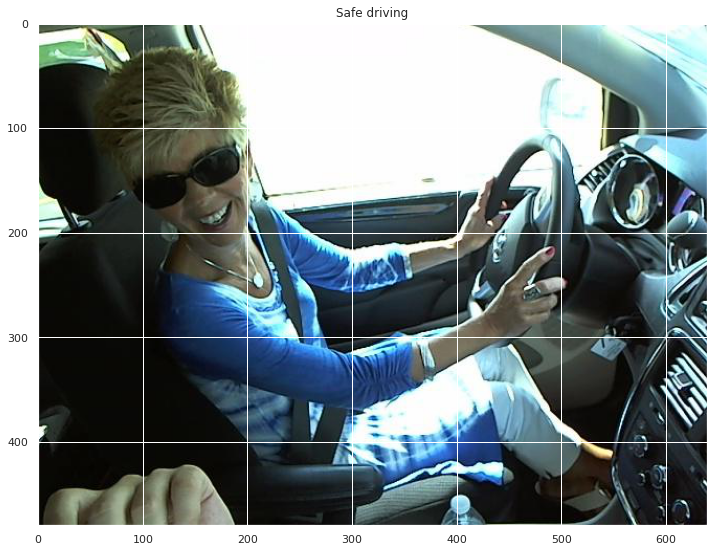

In [65]:
plt.figure(figsize = (12, 20))
#image_count = 1
DIR = '../input/state-farm-distracted-driver-detection/imgs/train/'

for directory in os.listdir(DIR):
    
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(DIR + directory)):
            if i == 2:
                break
            else:
                #fig = plt.subplot(2, 2, image_count)
                #image_count += 1
                image = mpimg.imread(DIR + directory + '/' + file)
                plt.imshow(image)
                plt.title(CAT_MAP[directory])

In [66]:
base_model  = tf.keras.applications.resnet.ResNet50(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = (224,224,3))
base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [67]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output =tf.keras.layers.Dense(CLASSES,activation = tf.nn.softmax)(x)
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [68]:
num_epochs = 50
def lr_schedule(epoch,lr):
    # Learning Rate Schedule

    lr = lr
    total_epochs = num_epochs

    check_1 = int(total_epochs * 0.9)
    check_2 = int(total_epochs * 0.8)
    check_3 = int(total_epochs * 0.6)
    check_4 = int(total_epochs * 0.4)

    if epoch > check_1:
        lr *= 1e-4
    elif epoch > check_2:
        lr *= 1e-3
    elif epoch > check_3:
        lr *= 1e-2
    elif epoch > check_4:
        lr *= 1e-1

    print("[+] Current Lr rate : {} ".format(lr))
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [69]:
history = model.fit(
      x = X_train,y=y_train,
      validation_data=(X_valid,y_valid),
      steps_per_epoch=16,
      batch_size = 8,
      epochs=num_epochs,
    
    callbacks = [lr_callback],
      verbose=1)

Epoch 1/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 19s 719ms/step - loss: 6.5458 - accuracy: 0.1142 - val_loss: 7.7004 - val_accuracy: 0.0883
Epoch 2/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 9s 621ms/step - loss: 6.6597 - accuracy: 0.0531 - val_loss: 8.2798 - val_accuracy: 0.0853
Epoch 3/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 9s 617ms/step - loss: 6.6800 - accuracy: 0.1141 - val_loss: 6.6674 - val_accuracy: 0.0826
Epoch 4/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 9s 615ms/step - loss: 5.6127 - accuracy: 0.0749 - val_loss: 9.9805 - val_accuracy: 0.0820
Epoch 5/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 9s 613ms/step - loss: 4.6466 - accuracy: 0.1150 - val_loss: 8.9837 - val_accuracy: 0.0930
Epoch 6/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [=

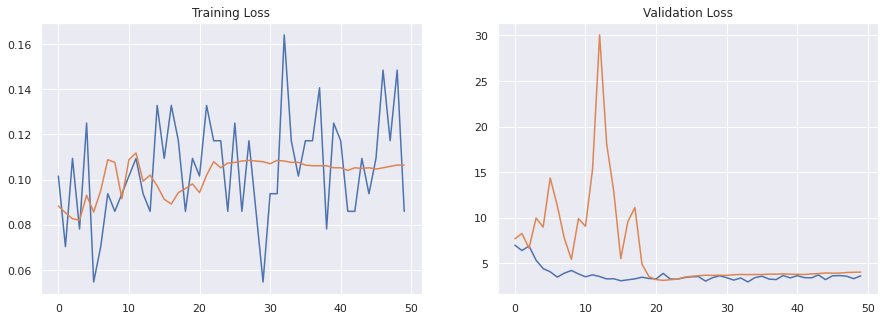

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

In [71]:
#Preparing data augmentation
'''Generate batches of tensor image data with real-time data augmentation.
   The data will be looped over (in batches).'''

train_gen = ImageDataGenerator(rescale = 1.0/255,
                               height_shift_range=0.5,
                               width_shift_range = 0.5,
                               rotation_range=30,
                               validation_split = 0.2)

valid_gen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [72]:
'''Takes the dataframe and the path to a directory + generates batches.

   The generated batches contain => augmented/normalized data.'''
BATCHES = 50

training_generator = train_gen.flow_from_directory('../input/state-farm-distracted-driver-detection/imgs/train', 
                                                 target_size = (IMG_SIZE, IMG_SIZE), 
                                                 batch_size = BATCHES,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")


validation_generator = valid_gen.flow_from_directory('../input/state-farm-distracted-driver-detection/imgs/train', 
                                                   target_size = (IMG_SIZE, IMG_SIZE), 
                                                   batch_size = BATCHES,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [73]:
train_samples = 17943
valid_samples = 4481

In [74]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.figure(figsize = (8, 5))
    #plt.xticks(np.arange(0, 10))
    #plt.yticks(np.arange(0, 100))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.figure(figsize = (8, 5))
    #plt.xticks(np.arange(0, 10))
    #plt.yticks(np.arange(0, 100))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    plt.show()

In [75]:
def VGG16_MODEL(img_rows=IMG_SIZE, img_cols=IMG_SIZE, color_type=3):
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model_2 = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model_2.layers:
        layer.trainable = False
        
    x = vgg16_model_2.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(CLASSES, activation = 'softmax')(x)

    model = Model(inputs = vgg16_model_2.input, outputs = predictions)
    
    return model

In [76]:
print("Loading network...")
model_vgg16_2 = VGG16_MODEL(img_rows=IMG_SIZE, img_cols=IMG_SIZE)

model_vgg16_2.summary()

model_vgg16_2.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
58892288/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________

In [77]:
# Model weights are saved at the end of every epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [78]:
checkpoint = ModelCheckpoint(filepath='./weights_best_vgg16_model2.hdf5', 
                               verbose=1, save_best_only=True)

In [79]:
history = model_vgg16_2.fit_generator(training_generator,
                         steps_per_epoch = 17943/50,
                         epochs = EPOCHS, 
                         callbacks=[early_stopping, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = 4481/50)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
358/358 [==============================] - 333s 924ms/step - loss: 2.2723 - accuracy: 0.1584 - val_loss: 1.9249 - val_accuracy: 0.2736

Epoch 00001: val_loss improved from inf to 1.92491, saving model to ./weights_best_vgg16_model2.hdf5
Epoch 2/50
358/358 [==============================] - 326s 909ms/step - loss: 1.9060 - accuracy: 0.3273 - val_loss: 1.5747 - val_accuracy: 0.4479

Epoch 00002: val_loss improved from 1.92491 to 1.57469, saving model to ./weights_best_vgg16_model2.hdf5
Epoch 3/50
358/358 [==============================] - 323s 901ms/step - loss: 1.7233 - accuracy: 0.3999 - val_loss: 1.2613 - val_accuracy: 0.5961

Epoch 00003: val_loss improved from 1.57469 to 1.26132, saving model to ./weights_best_vgg16_model2.hdf5
Epoch 4/50
358/358 [==============================] - 324s 904ms/step - loss: 1.5956 - accuracy: 0.4419 - val_loss: 1.1359 - val_accuracy: 0.5927

Epoch 00004: val_loss improved from 1.26132 to 1.13591, saving model to ./weights_best_vgg16_model2.h

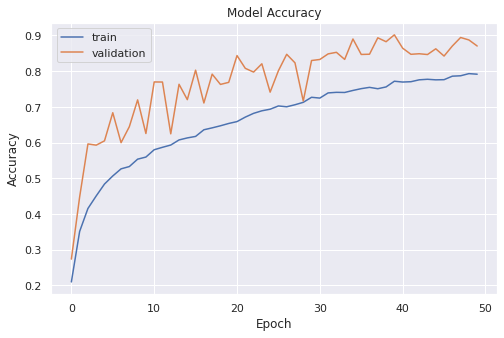

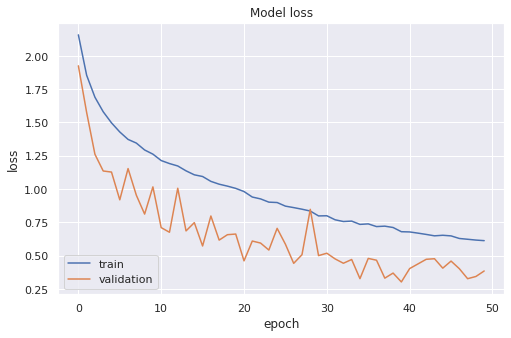

In [80]:
plot_train_history(history)

1/1 [==============================] - 0s 343ms/step
[[1.0909627e-05 9.0404235e-08 1.9855822e-06 1.3905703e-04 1.7472519e-02
  2.5071062e-02 3.7428817e-06 6.1044659e-05 9.2196941e-01 3.5270091e-02]]
Y Prediction: 8
Predicted as: Hair and makeup


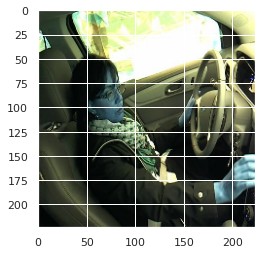

1/1 [==============================] - 0s 16ms/step
[[2.90461089e-02 1.18927914e-04 1.47357826e-09 1.95322707e-02
  5.02161589e-03 9.42900121e-01 1.81827227e-06 6.03828084e-06
  1.44331402e-03 1.92973448e-03]]
Y Prediction: 5
Predicted as: Operating the radio


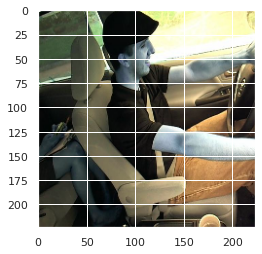

1/1 [==============================] - 0s 16ms/step
[[1.70310646e-01 9.38926339e-02 2.50434732e-06 6.68366920e-06
  1.41896415e-08 6.76346247e-07 1.46906168e-04 6.68985844e-02
  6.07242286e-01 6.14990816e-02]]
Y Prediction: 8
Predicted as: Hair and makeup


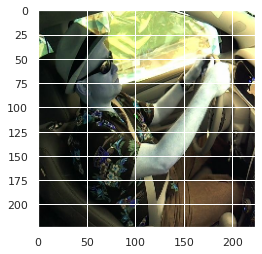

1/1 [==============================] - 0s 16ms/step
[[1.5508540e-09 1.7955032e-11 7.1218057e-04 9.2035815e-12 1.1485996e-07
  4.0009720e-08 4.0489238e-07 1.3926700e-07 9.9928504e-01 2.1819997e-06]]
Y Prediction: 8
Predicted as: Hair and makeup


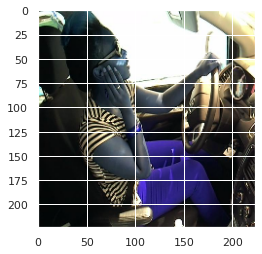

1/1 [==============================] - 0s 16ms/step
[[2.7270382e-05 4.9638952e-04 1.8308787e-08 9.2689109e-01 7.0636749e-02
  1.1544369e-06 5.5134692e-06 8.0687314e-04 1.1346183e-03 4.2421470e-07]]
Y Prediction: 3
Predicted as: Texting - left


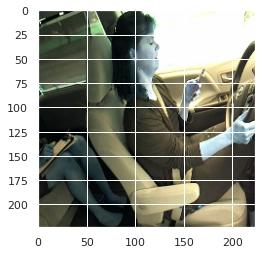

1/1 [==============================] - 0s 16ms/step
[[1.7217717e-06 4.1283448e-03 6.0034755e-09 9.6351564e-01 8.8216941e-05
  6.7102381e-05 5.6806931e-07 1.0677418e-04 3.2065291e-02 2.6317020e-05]]
Y Prediction: 3
Predicted as: Texting - left


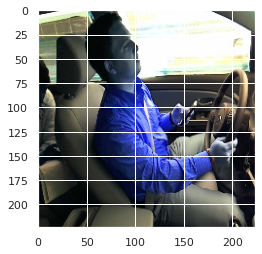

1/1 [==============================] - 0s 16ms/step
[[4.1473278e-09 6.9507450e-08 7.9734855e-06 2.3530545e-06 1.6195937e-06
  9.7509709e-12 4.7252530e-07 1.2947789e-02 9.8703718e-01 2.4598282e-06]]
Y Prediction: 8
Predicted as: Hair and makeup


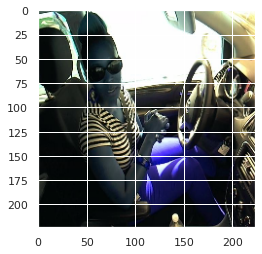

1/1 [==============================] - 0s 17ms/step
[[1.8193403e-02 3.9791134e-01 1.2619345e-03 7.8429831e-03 9.6988678e-04
  2.3737947e-04 4.5702080e-03 7.7555731e-02 4.3745819e-01 5.3998962e-02]]
Y Prediction: 8
Predicted as: Hair and makeup


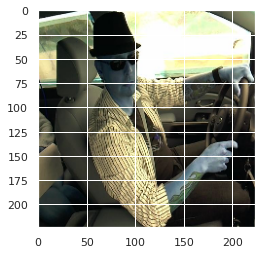

1/1 [==============================] - 0s 16ms/step
[[8.0848875e-04 7.7182590e-04 3.7514532e-05 6.2282692e-05 1.0443661e-02
  7.3881015e-02 2.0437276e-02 7.5071730e-04 8.9251250e-01 2.9474194e-04]]
Y Prediction: 8
Predicted as: Hair and makeup


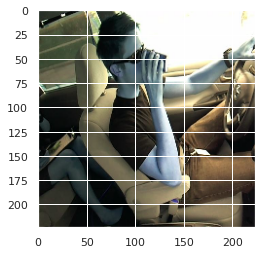

1/1 [==============================] - 0s 16ms/step
[[9.2099683e-05 5.5437940e-01 6.8814035e-05 2.3076514e-04 8.4885099e-04
  1.5808979e-08 1.1024912e-05 4.4427258e-01 9.0515605e-05 5.9085364e-06]]
Y Prediction: 1
Predicted as: Texting - right


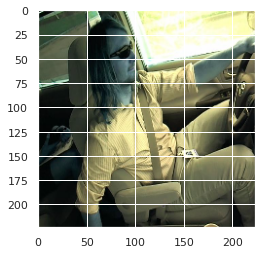

In [81]:
def prediction():
    for i in np.arange(10):
        img_brute = test_data[i]

        im = cv2.resize(cv2.cvtColor(img_brute, cv2.COLOR_BGR2RGB), (IMG_SIZE,IMG_SIZE)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)

        img_display = cv2.resize(img_brute,(IMG_SIZE,IMG_SIZE))
        plt.imshow(img_display, cmap='gray')

        y_preds = model_vgg16_2.predict(im, batch_size=BATCHES, verbose=1)
        print(y_preds)
        y_prediction = np.argmax(y_preds)
        print('Y Prediction: {}'.format(y_prediction))
        print('Predicted as: {}'.format(CAT_MAP.get('c{}'.format(y_prediction))))

        plt.show()
prediction()

In [83]:
model_vgg16_2.save('./newCnn.h5')

In [84]:
model=keras.models.load_model("./newCnn.h5")